In [1]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import ast
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('opinion_lexicon')
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import stopwords
import re
import string
from afinn import Afinn
from nrclex import NRCLex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /home/endriu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/endriu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/endriu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/endriu/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/endriu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/endriu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('top450-aita-balanced-comments.csv')

In [3]:
for level in ['level1_bodies', 'level2_bodies', 'level3_bodies']:
    df[level] = df[level].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

def make_level_df(df, level_col, level_num):
    temp = df[['submission_id', 'author', 'flair', level_col]].copy()
    temp = temp.rename(columns={level_col: 'comment'})
    temp['level'] = level_num
    return temp.explode('comment').dropna(subset=['comment'])

level1_df = make_level_df(df, 'level1_bodies', 1)
level2_df = make_level_df(df, 'level2_bodies', 2)
level3_df = make_level_df(df, 'level3_bodies', 3)

comments_df = pd.concat([level1_df, level2_df, level3_df], ignore_index=True)
print(comments_df.shape)
print(comments_df.iloc[0])

(83342, 5)
submission_id                                               achoyx
author                                        GirlFriendRestaurant
flair                                                      Asshole
comment          As a chef: yes, YTA.\n\nYou’re expecting her t...
level                                                            1
Name: 0, dtype: object


In [4]:
comments_df['comment'] = (
    comments_df['comment']
    .str.replace('\n', ' ', regex=False)
    .str.replace('\s+', ' ', regex=True)
    .str.strip()
)
comments = comments_df['comment']
print(len(comments))
print(comments[0])

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2723/3669009923.py:4: SyntaxWarning: invalid escape sequence '\s'
  .str.replace('\s+', ' ', regex=True)


83342
As a chef: yes, YTA. You’re expecting her to put in shit ton of effort, without rewarding it, and never paying back. I promise you, if she’s a foodie, she desperately want to go out and eat and experience what other people do, and not put in all the effort all the time. And no, it’s not an excuse. Tastebuds get dulled. Even as a chef, I’m never as impressed by my own food as others tell me I should be.


In [5]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess_with_emotion(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [6]:
comments_token = [preprocess_with_emotion(x) for x in comments]

In [7]:
more_stop = ['yta', 'nta', 'would', 'like', 'op']
uninformative_words = [
    'get', 'got', 'gets', 'getting',
    'one', 'two', 'three', 'four', 'five',
    'even', 'ever', 'still', 'yet',
    'thing', 'things', 'something', 'anything', 'everything', 'nothing',
    'someone', 'anyone', 'everyone', 'nobody',
    'way', 'ways', 'lot', 'lots',
    'stuff', 'kind', 'kinds', 'type', 'types',
    'make', 'makes', 'made', 'making',
    'take', 'takes', 'taken', 'taking',
    'look', 'looks', 'looked', 'looking',
    'use', 'uses', 'used', 'using',
    'say', 'says', 'said',
    'go', 'goes', 'went', 'gone', 'going',
    'come', 'comes', 'came', 'coming',
    'thing', 'things',
    'much', 'many', 'more', 'most', 'few', 'less', 'least',
    'really', 'quite', 'rather', 'pretty',
    'might', 'could', 'would', 'should',
    'just', 'also', 'well',
    'done', 'doing',
    'back', 'away', 'around',
    'right', 'left', 'place', 'point', 'area',
    'part', 'parts', 'whole',
    'start', 'started', 'starting',
    'end', 'ended', 'ending'
]
stop = stopwords.words('english') + more_stop + uninformative_words
more_punct = '’“”'
punctuation = string.punctuation + more_punct

def preprocess_punct(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords and lowercase
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation

comments_pp = [preprocess_punct(x) for x in comments_token]

In [8]:
def get_counter(df):
  sentences = (list(itertools.chain(df)))
  flat_list = [item for sublist in sentences for item in sublist]
  c = Counter(flat_list)
  return c

c_tot = get_counter(comments_pp)
c_tot.most_common(50)

[('people', 11833),
 ('think', 10008),
 ('time', 9533),
 ('know', 8844),
 ('family', 8755),
 ('want', 8000),
 ('kids', 7122),
 ('parents', 6920),
 ('wife', 6607),
 ('daughter', 5746),
 ('good', 5609),
 ('husband', 5535),
 ('mom', 5447),
 ('need', 5397),
 ('son', 5337),
 ('never', 5293),
 ('child', 5275),
 ('see', 5040),
 ('life', 5030),
 ('feel', 4968),
 ('sister', 4651),
 ('kid', 4288),
 ('asshole', 4180),
 ("that's", 4148),
 ('person', 4146),
 ('wedding', 4135),
 ('tell', 4103),
 ('money', 4091),
 ('dad', 4070),
 ('probably', 3971),
 ('work', 3947),
 ('first', 3903),
 ('let', 3900),
 ('years', 3880),
 ('sure', 3861),
 ('home', 3838),
 ('needs', 3774),
 ('day', 3656),
 ('house', 3505),
 ('better', 3468),
 ('sounds', 3458),
 ('give', 3450),
 ('love', 3444),
 ('relationship', 3441),
 ('help', 3409),
 ('mother', 3384),
 ('friends', 3320),
 ("can't", 3312),
 ('maybe', 3306),
 ('wrong', 3291)]

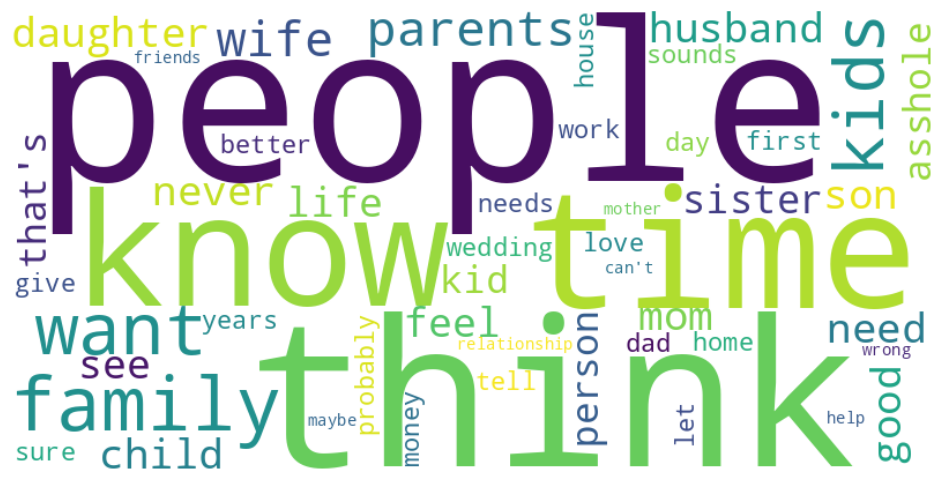

In [9]:
word_freq_dict = dict(c_tot.most_common(50))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_all.png', bbox_inches='tight')
plt.show()

In [10]:
yta_comments = comments_df[comments_df['flair'] == 'Asshole']['comment']
nta_comments = comments_df[comments_df['flair'] == 'Not the A-hole']['comment']
print(len(yta_comments))
print(len(nta_comments))

43125
40217


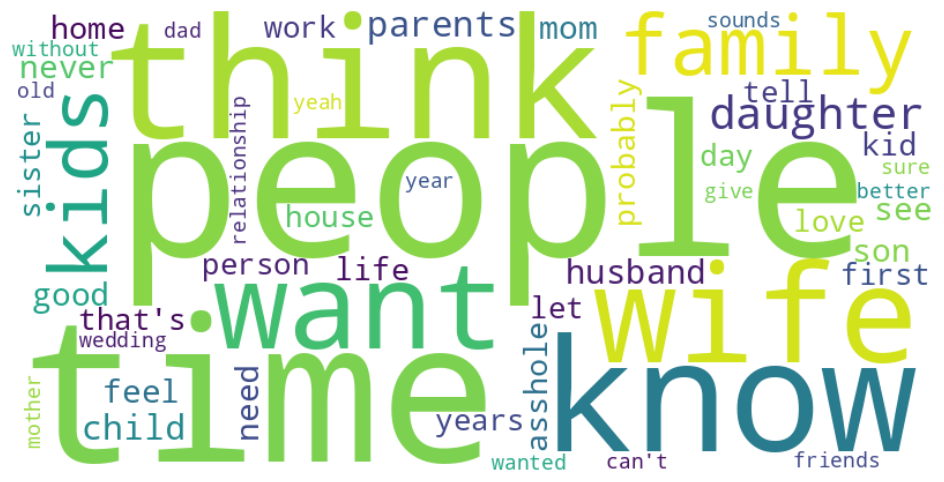

In [11]:
yta_comments_token = [preprocess_with_emotion(x) for x in yta_comments]
yta_comments_pp = [preprocess_punct(x) for x in yta_comments_token]

c_yta = get_counter(yta_comments_pp)
c_yta.most_common(50)

word_freq_dict_yta = dict(c_yta.most_common(50))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_yta)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_yta.png', bbox_inches='tight')
plt.show()

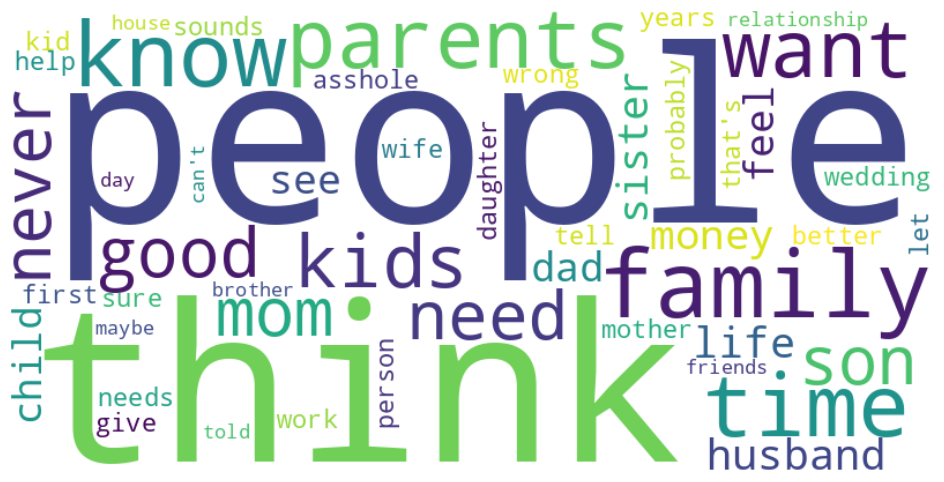

In [12]:
nta_comments_token = [preprocess_with_emotion(x) for x in nta_comments]
nta_comments_pp = [preprocess_punct(x) for x in nta_comments_token]

c_nta = get_counter(nta_comments_pp)
c_nta.most_common(50)

word_freq_dict_nta = dict(c_nta.most_common(50))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_nta)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_nta.png', bbox_inches='tight')
plt.show()

In [7]:
afinn = Afinn()
comments_df['afinn'] = comments.apply(afinn.score)
print(comments_df.iloc[0])

submission_id                                               achoyx
author                                        GirlFriendRestaurant
flair                                                      Asshole
comment          As a chef: yes, YTA. You’re expecting her to p...
level                                                            1
afinn                                                         -1.0
Name: 0, dtype: object


In [ ]:
def get_emotion_score(sentence):
    text_object = NRCLex(sentence)
    emotions = text_object.raw_emotion_scores
    pos = emotions.get('positive', 0)
    neg = emotions.get('negative', 0)
    return pos - neg

comments_df['ncrlex'] = comments.apply(get_emotion_score)

In [11]:
def vader_score(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

comments_df["vader"] = comments.apply(vader_score)

In [19]:
comments_df.to_csv('comments.csv')

In [13]:
comments_bert = pd.read_csv('comments_with_bert.csv')
print(comments_bert.head())

   Unnamed: 0.1  Unnamed: 0 submission_id                author    flair  \
0             0           0        achoyx  GirlFriendRestaurant  Asshole   
1             1           1        achoyx  GirlFriendRestaurant  Asshole   
2             2           2        achoyx  GirlFriendRestaurant  Asshole   
3             3           3        achoyx  GirlFriendRestaurant  Asshole   
4             4           4        achoyx  GirlFriendRestaurant  Asshole   

                                             comment  level  afinn  ncrlex  \
0  As a chef: yes, YTA. You’re expecting her to p...      1   -1.0       3   
1  YTA. Imagine you're the best in the world at j...      1    3.0       1   
2  YTA. You sound EXACTLY like my SO. It’s crazy....      1   -3.0       0   
3  >It's gotten to the point where I don't see an...      1    1.0       3   
4  Oh dear, you’re totally TA What’s your hobby? ...      1   12.0       7   

    vader  bert_score  
0 -0.8382     -0.6647  
1  0.6369     -0.3186  
2 

In [14]:
level_scores = comments_bert.groupby(['submission_id', 'level', 'flair']).agg({
    'afinn': 'mean',
    'ncrlex': 'mean',
    'vader': 'mean',
    'bert_score': 'mean'
}).reset_index()

print(level_scores.shape)
print(level_scores.iloc[0])

(1346, 7)
submission_id           100ogg4
level                         1
flair            Not the A-hole
afinn                      -0.5
ncrlex                     2.18
vader                  0.059854
bert_score            -0.662976
Name: 0, dtype: object


In [15]:
submission_scores = comments_bert.groupby(['submission_id', 'flair']).agg({
    'afinn': 'mean',
    'ncrlex': 'mean',
    'vader': 'mean',
    'bert_score': 'mean'
}).reset_index()

print(submission_scores.shape)
print(submission_scores.iloc[0])

(450, 6)
submission_id           100ogg4
flair            Not the A-hole
afinn                   -0.3125
ncrlex                  1.48125
vader                  0.113915
bert_score            -0.527917
Name: 0, dtype: object


In [16]:
# Get overall mean and std for each score type, grouped by flair
summary_stats = submission_scores.groupby('flair')[['afinn', 'ncrlex', 'vader', 'bert_score']].agg(['mean', 'std']).reset_index()

# Optionally flatten column names
summary_stats.columns = ['flair'] + [f'{col}_{stat}' for col, stat in summary_stats.columns[1:]]

print(summary_stats)

            flair  afinn_mean  afinn_std  ncrlex_mean  ncrlex_std  vader_mean  \
0         Asshole   -0.141203   1.575380     0.703284    0.685889    0.083321   
1  Not the A-hole   -0.476751   1.483802     0.637185    0.651914    0.063592   

   vader_std  bert_score_mean  bert_score_std  
0   0.146049        -0.427240        0.146269  
1   0.144223        -0.399886        0.163375  


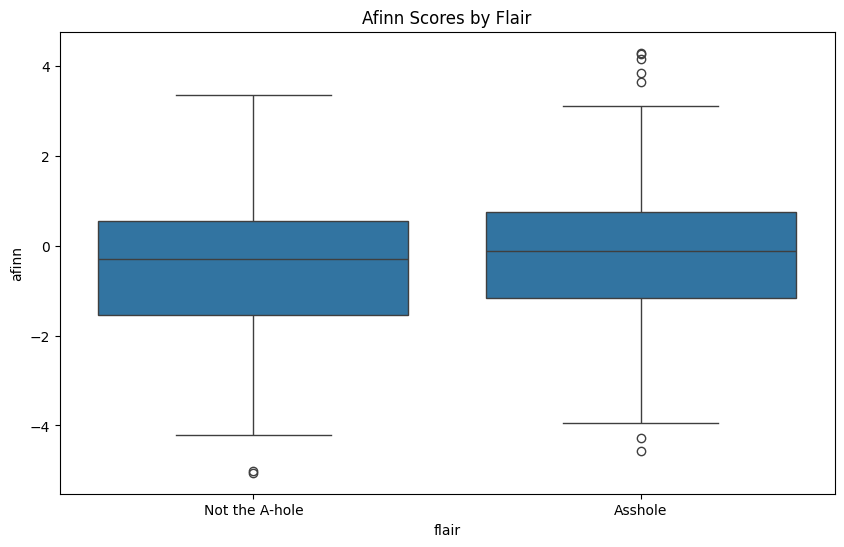

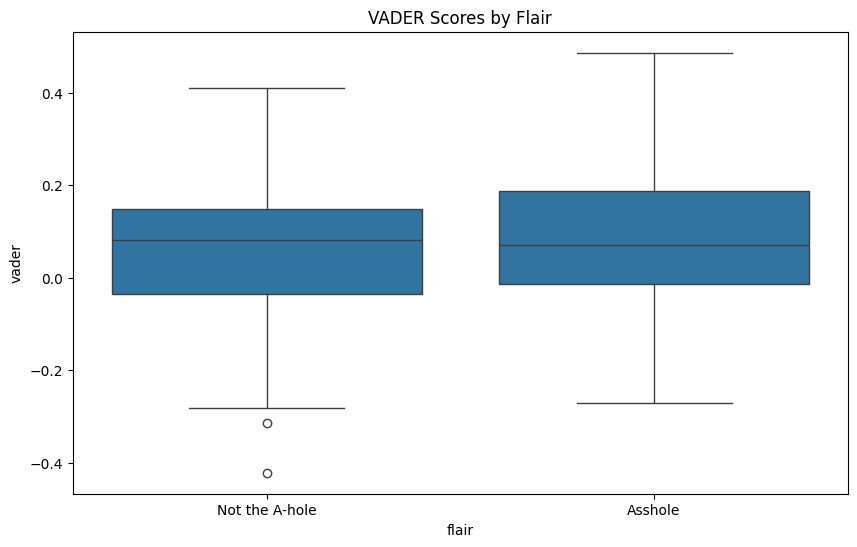

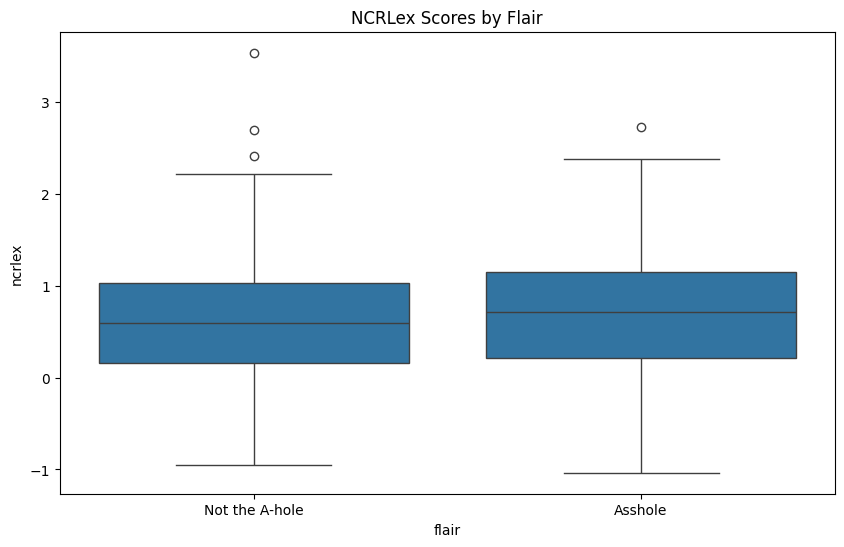

In [5]:
# Plotting afinn scores by flair
plt.figure(figsize=(10, 6))
sns.boxplot(data=submission_scores, x='flair', y='afinn')
plt.title('Afinn Scores by Flair')
plt.savefig('afinn_flair.png', bbox_inches='tight')
plt.show()

# Plotting vader scores by flair
plt.figure(figsize=(10, 6))
sns.boxplot(data=submission_scores, x='flair', y='vader')
plt.title('VADER Scores by Flair')
plt.savefig('vader_flair.png', bbox_inches='tight')
plt.show()

# Plotting ncrlex scores by flair
plt.figure(figsize=(10, 6))
sns.boxplot(data=submission_scores, x='flair', y='ncrlex')
plt.title('NCRLex Scores by Flair')
plt.savefig('ncrlex_flair.png', bbox_inches='tight')
plt.show()

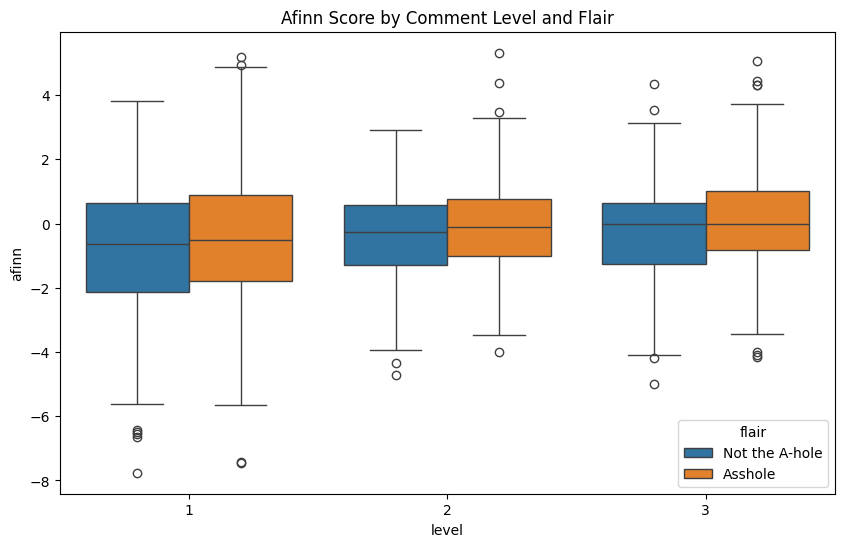

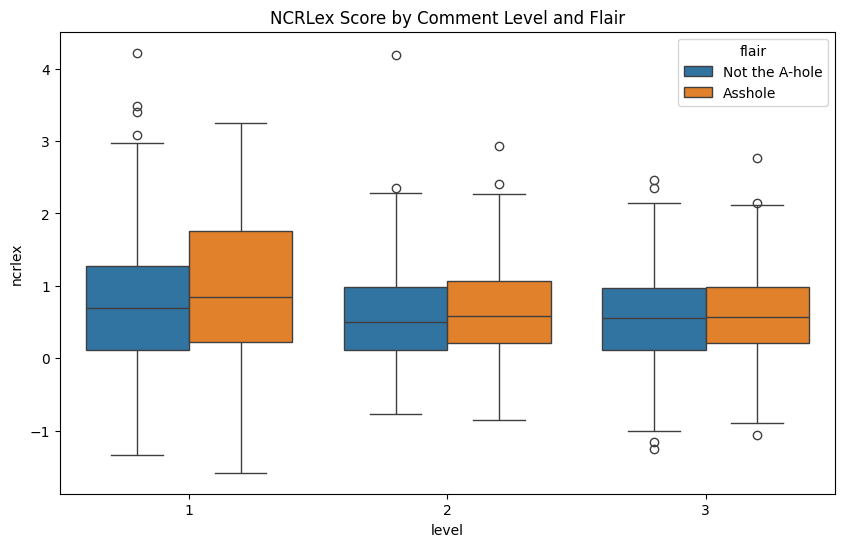

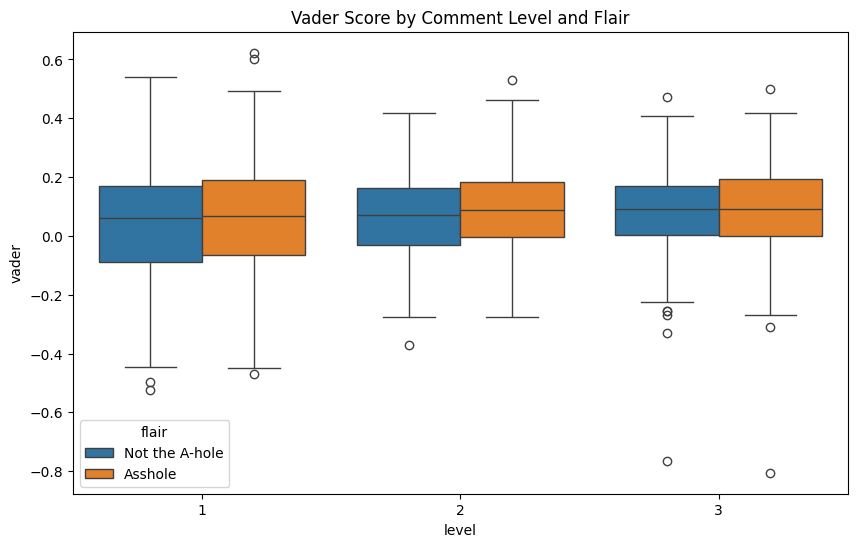

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=level_scores, x='level', y='afinn', hue='flair')
plt.title('Afinn Score by Comment Level and Flair')
plt.savefig('afinn_level.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=level_scores, x='level', y='ncrlex', hue='flair')
plt.title('NCRLex Score by Comment Level and Flair')
plt.savefig('ncrlex_level.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=level_scores, x='level', y='vader', hue='flair')
plt.title('Vader Score by Comment Level and Flair')
plt.savefig('vader_level.png', bbox_inches='tight')
plt.show()

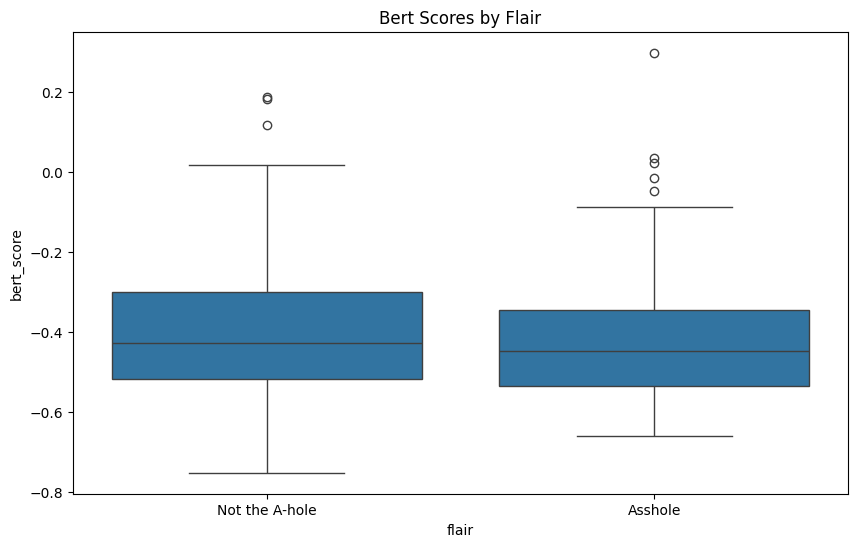

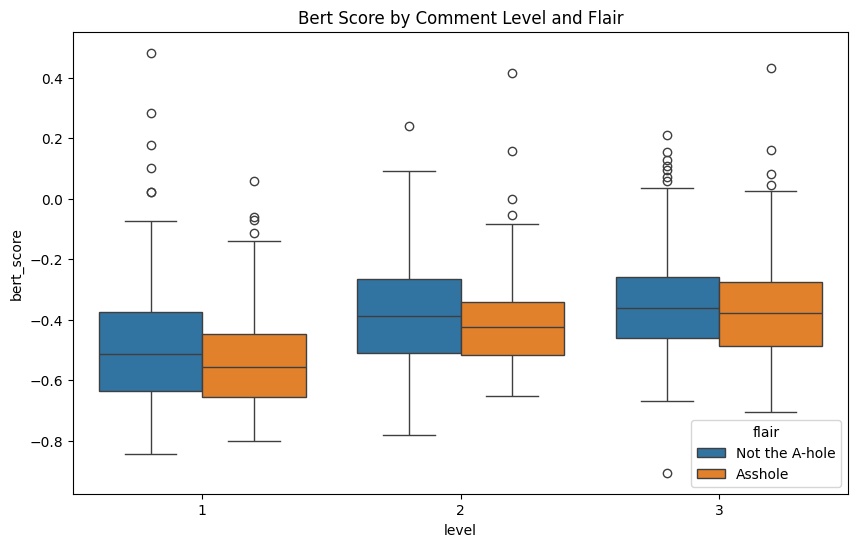

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=submission_scores, x='flair', y='bert_score')
plt.title('Bert Scores by Flair')
plt.savefig('bert_flair.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=level_scores, x='level', y='bert_score', hue='flair')
plt.title('Bert Score by Comment Level and Flair')
plt.savefig('bert_level.png', bbox_inches='tight')
plt.show()

In [66]:
max_comment = comments_bert.loc[comments_bert['bert_score'].idxmax(), 'comment']
max_level = comments_bert.loc[comments_bert['bert_score'].idxmax(), 'level']
print(max_comment)
print(max_level)

I really like this one. Also, Emiliano is an awesome name, I love it, stay proud of it, my guy!!
2


In [60]:
selftext_df = pd.read_csv('submissions_bert.csv')
selftext_df = selftext_df[['id', 'link_flair_text', 'bert_score']]
print(selftext_df.iloc[0])

id                  achoyx
link_flair_text    Asshole
bert_score           0.172
Name: 0, dtype: object


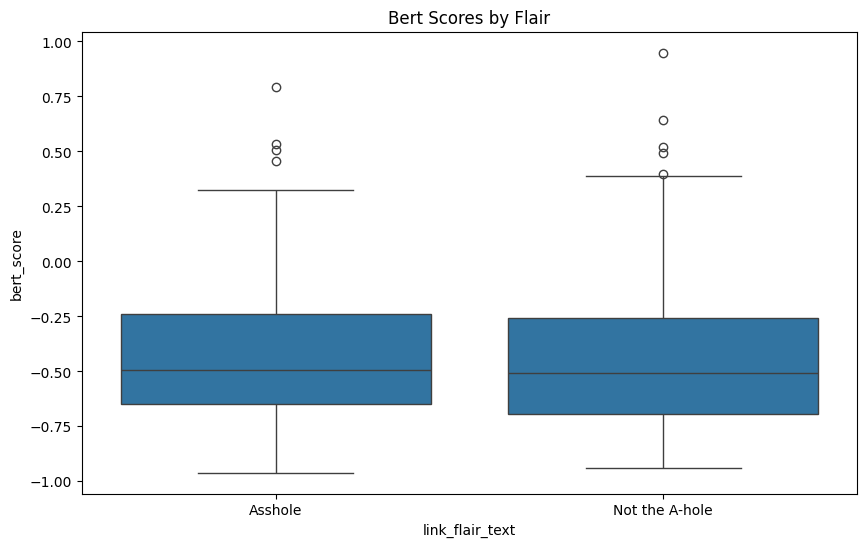

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=selftext_df, x='link_flair_text', y='bert_score')
plt.title('Bert Scores by Flair')
plt.show()

In [19]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene

# --- Prepare the data ---
# Filter the two flair groups from your submission_scores DataFrame
nta_scores = submission_scores[submission_scores['flair'] == 'Not the A-hole']
yta_scores = submission_scores[submission_scores['flair'] == 'Asshole']

# List of sentiment score columns to test
score_columns = ['afinn', 'ncrlex', 'vader', 'bert_score']

# --- Perform and print the analysis for each score ---
for score_column in score_columns:
    print(f"--- Analyzing: {score_column} ---")
    
    # Extract the scores for each group
    nta_sample = nta_scores[score_column]
    yta_sample = yta_scores[score_column]
    
    # --- 1. Assumption Checking ---
    print("\n1. Assumption Checks:")
    
    # Shapiro-Wilk Test for Normality
    shapiro_nta_stat, shapiro_nta_p = shapiro(nta_sample)
    shapiro_yta_stat, shapiro_yta_p = shapiro(yta_sample)
    print(f"   Shapiro-Wilk (NTA): p={shapiro_nta_p:.4f}")
    print(f"   Shapiro-Wilk (YTA): p={shapiro_yta_p:.4f}")
    if shapiro_nta_p < 0.05 or shapiro_yta_p < 0.05:
        print("   -> At least one sample is not normally distributed.")
    else:
        print("   -> Both samples appear to be normally distributed.")

    # Levene's Test for Homogeneity of Variances
    levene_stat, levene_p = levene(nta_sample, yta_sample)
    print(f"   Levene's Test (Equal Variances): p={levene_p:.4f}")
    if levene_p < 0.05:
        print("   -> Variances are not equal.")
    else:
        print("   -> Variances are equal.")

    # --- 2. Statistical Tests ---
    print("\n2. Statistical Test Results:")

    # Independent Samples t-test
    # We use equal_var=False if Levene's test p < 0.05 (Welch's t-test)
    t_stat, t_p = ttest_ind(nta_sample, yta_sample, equal_var=(levene_p >= 0.05))
    print(f"   Independent t-test: t-statistic={t_stat:.4f}, p-value={t_p:.4f}")

    # Mann-Whitney U test (non-parametric)
    u_stat, u_p = mannwhitneyu(nta_sample, yta_sample)
    print(f"   Mann-Whitney U test: U-statistic={u_stat:.4f}, p-value={u_p:.4f}")
    
    # --- 3. Interpretation ---
    print("\n3. Interpretation:")
    alpha = 0.05
    if u_p < alpha:
        print(f"   The difference in '{score_column}' scores between the flairs is statistically significant (p < {alpha}).")
    else:
        print(f"   There is no statistically significant difference in '{score_column}' scores between the flairs (p >= {alpha}).")
    
    print("-" * 50 + "\n")

--- Analyzing: afinn ---

1. Assumption Checks:
   Shapiro-Wilk (NTA): p=0.1096
   Shapiro-Wilk (YTA): p=0.2470
   -> Both samples appear to be normally distributed.
   Levene's Test (Equal Variances): p=0.6934
   -> Variances are equal.

2. Statistical Test Results:
   Independent t-test: t-statistic=-2.3257, p-value=0.0205
   Mann-Whitney U test: U-statistic=22584.5000, p-value=0.0480

3. Interpretation:
   The difference in 'afinn' scores between the flairs is statistically significant (p < 0.05).
--------------------------------------------------

--- Analyzing: ncrlex ---

1. Assumption Checks:
   Shapiro-Wilk (NTA): p=0.0008
   Shapiro-Wilk (YTA): p=0.9045
   -> At least one sample is not normally distributed.
   Levene's Test (Equal Variances): p=0.2484
   -> Variances are equal.

2. Statistical Test Results:
   Independent t-test: t-statistic=-1.0478, p-value=0.2953
   Mann-Whitney U test: U-statistic=23487.0000, p-value=0.1858

3. Interpretation:
   There is no statistically s